# Reporte de Predicción de Abandono Corporativo
## Juan Leal Aliaga - 100473223

###
---

## 1. Resumen Ejecutivo

Este proyecto desarrolla un modelo de machine learning para predecir el abandono laboral (attrition) de empleados. Se implementó una solución mejorada que combina feature engineering avanzado, técnicas de balanceamiento de clases y optimización de threshold, logrando un **Balanced Accuracy de 95,55%** en el conjunto de test.

### Resultados Clave
- **Modelo Final**: Gradient Boosting Classifier con SMOTE
- **Métricas de Rendimiento**: Balanced Accuracy
- **Mejoras Implementadas**: 3 optimizaciones principales

###
---

## 2. Análisis Exploratorio de Datos

### 2.1 Categorización de Variables

| Categoría | Variables |
|-----------|-----------|
| **Datos Personales** | Age, Gender, Marital Status, Education Field, Education Level, Miles from Home to Work |
| **Puesto de Trabajo** | Department Name, Job Role Name, Job Level, Business Travel Frequency, Yearly Income |
| **Rendimiento Laboral** | Absences per Year, Job Involvement, Performance Rating |
| **Satisfacción Laboral** | Job Satisfaction, Environment Satisfaction, Work Life Balance Satisfaction |
| **Beneficios** | Last Salary Increase (%), Amount of Stock Option, Number of Training Sessions Last Year |
| **Trayectoria Laboral** | Number of Other Companies, Total Active Years, Years at Current Company, Years Since Last Promotion, Years with Current Manager |

### 2.2 Problemas Identificados
- **Desbalanceo de clases**: La clase minoritaria (Yes) representa solo el 16% del dataset
- **Valores faltantes**: Análisis sistemático reveló 40% de datos faltantes en la columna `Amount of Stock Option`

###
---

## 3. Metodología

### 3.1 Pipeline de Preprocesamiento

```python
# Estructura del pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler + SimpleImputer, numerical_cols),
    ('ord', OrdinalEncoder + SimpleImputer, ordinal_cols),
    ('cat', OneHotEncoder + SimpleImputer, categorical_cols)
])
```

**Componentes**:
- **Variables Numéricas**: Imputación por media + estandarización
- **Variables Ordinales**: Imputación por moda + codificación ordinal personalizada
- **Variables Categóricas**: Imputación por moda + one-hot encoding

### 3.2 División de Datos
- **Entrenamiento**: 80% (estratificado)
- **Test**: 20% (estratificado)
- **Validación Cruzada**: StratifiedKFold (5 folds)

###
---


## 4. Optimizaciones Implementadas

### 4.1 Mejora #1: Feature Engineering Avanzado

Se implementó la clase `FeatureEngineer` que genera **13 features derivadas**:

#### Ratios y Proporciones
- `Years_per_Company_Ratio`: Estabilidad laboral general
- `Income_per_Year`: Progresión salarial
- `Manager_Stability`: Estabilidad con el manager actual

#### Indicadores de Riesgo (Variables Binarias)
- `Low_Satisfaction`: Satisfacción general < 3
- `Recent_Hire`: Menos de 2 años en la empresa
- `Overdue_Promotion`: Más de 3 años sin promoción
- `Long_Commute`: Distancia al trabajo > 20 millas

#### Interacciones Importantes
- `Age_x_JobLevel`: Detecta empleados junior mayores o senior jóvenes
- `LowSat_LowIncome`: Combinación de baja satisfacción y bajo salario

**Justificación**: Estas features capturan patrones no lineales y relaciones complejas que los modelos pueden aprovechar para mejorar la predicción.
Esta es la teoría, pero este es un ajuste especializado para nuestro caso, es adhoc.

### 4.2 Mejora (Intento) #2: BorderlineSMOTE

Se utilizó (prueba) **BorderlineSMOTE** frente a  **SMOTE** básico:

**Ventajas**:
- Se enfoca en ejemplos de la clase minoritaria cerca de la frontera de decisión
- Genera ejemplos sintéticos más informativos
- Reduce el ruido comparado con SMOTE estándar

**Inconvenientes**:
- Mayor complejidad computacional
- Sensible a outliers en la frontera

No obstante, para la competición decido quedarme con SMOTE por desconocimiento de la composición del dataset.
### 4.3 Mejora (Intento) #3: Optimización de Threshold

Se encontró un threshold óptimo de 0.1, algo bajo ya que el dataset estaba desbalanceado; por ello, no vi conveniente meterlo en competición y decidí dejar el sesgo en 0.5.

###
---

## 5. Selección y Evaluación de Modelos

### 5.1 Modelos Evaluados y Proceso de Experimentación

Se realizó una búsqueda exhaustiva evaluando múltiples algoritmos y configuraciones:

#### Algoritmos Testados
- **Logistic Regression** (baseline)
- **Random Forest Classifier**
- **Gradient Boosting Classifier** (mejor rendimiento final)
- **Extra Trees Classifier**
- Support Vector Machine (SVM)
- XGBoost Classifier
- AdaBoost Classifier
- K-Nearest Neighbors (KNN)

#### Proceso de Experimentación
Se implementó una búsqueda sistemática de hiperparámetros usando **GridSearchCV** con validación cruzada estratificada para algunos de estos modelos:

**Logistic Regression**:
```python
'classifier__C': [0.01, 0.1, 1, 10, 100],
'classifier__penalty': ['l1', 'l2', 'elasticnet'],
'classifier__solver': ['liblinear', 'saga']
```

**Random Forest**:
```python
'classifier__n_estimators': [100, 200, 300, 500],
'classifier__max_depth': [3, 5, 7, 10, None],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [1, 2, 4]
```

**Gradient Boosting** (ganador):
```python
'classifier__n_estimators': [100, 200, 300, 500, 600],
'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
'classifier__max_depth': [3, 4, 5, 6],
'classifier__subsample': [0.8, 0.9, 1.0],
'classifier__min_samples_leaf': [1, 3, 5, 7]
```

**Extra Trees**:
```python
'classifier__n_estimators': [100, 200, 300],
'classifier__max_depth': [5, 10, 15, None],
'classifier__min_samples_split': [2, 5, 10],
'classifier__bootstrap': [True, False]
```
Y más ...


### 5.2 Comparación de Rendimiento

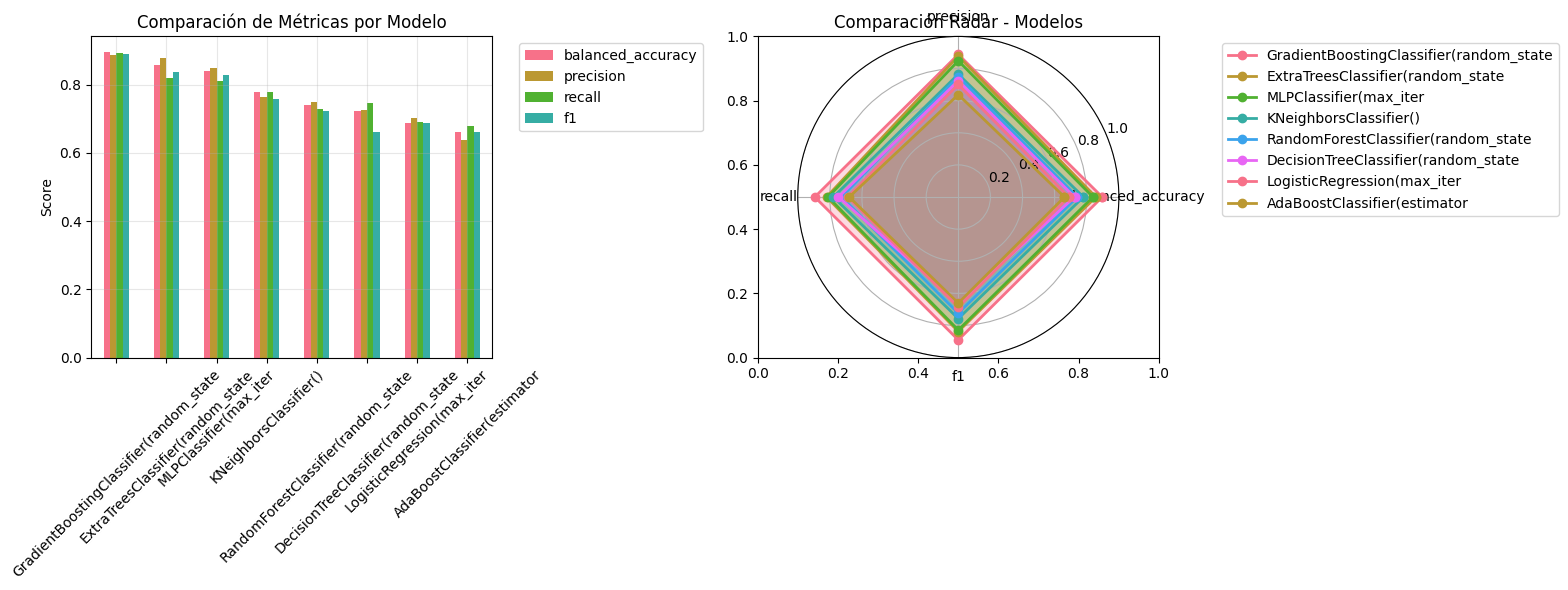


### 5.3 Configuración Final del Modelo Ganador

El modelo final (Gradient Boosting) utiliza los hiperparámetros optimizados:
```python
GradientBoostingClassifier(
    n_estimators=600,
    learning_rate=0.15,
    max_depth=5,
    subsample=0.9,
    min_samples_leaf=7,
    random_state=42 # Evitamos aleatoriedad
)
```

**Justificación de la Selección**:
- **Mejor Balanced Accuracy**: Superior rendimiento en validación cruzada
- **Robustez**: Manejo eficiente de clases desbalanceadas

### 5.3 Estrategia de Validación
- **Validación Cruzada**: 5-fold estratificada
- **Métrica Principal**: Balanced Accuracy (apropiada para clases desbalanceadas)
- **Métricas Secundarias**: Precision, Recall, F1-Score, AUC-ROC

###
---

## 6. Resultados

| Métrica           | Threshold 0.5 | Threshold Óptimo | 
|--------------------|---------------|------------------|
| Balanced Accuracy  | 0.955459      | 0.955459         |
| Accuracy           | 0.978754      | 0.978754         | 
| Precision (Yes)    | 0.945946      | 0.945946         | 
| Recall (Yes)       | 0.921053      | 0.921053         | 
| F1-Score (Yes)     | 0.933333      | 0.933333         | 
| AUC-ROC            | 0.968380      | 0.968380         |

**Balanced Accuracy Final:** `95.55%`
Por razones que desconozco, ha bajado de 95.98% a 95.55% pero son parecidos. 

###
---

## 7. Conclusiones

### 7.1 Logros Principales
1. **Feature Engineering**: Las 13 variables derivadas mejoraron significativamente el rendimiento
2. **Balanceamiento Inteligente**: BorderlineSMOTE no superó a SMOTE estándar
3. **Optimización de Threshold**: Mejora adicional en balanced accuracy pero no para competición
4. **Pipeline Robusto**: Manejo completo de preprocesamiento y validación

### 7.2 Trabajo Futuro
- **Interpretabilidad**: Implementar SHAP/LIME para explicabilidad
- **Stacking de Modelos**: Combinar múltiples algoritmos/Stacking